# Expérience basique
## Obtenir le seul de la `max` limite
### Description
Le but de cette expérience est de monitorer les performances de charges de travail séquentielle et aléatoire pour différentes valeurs de `max` limite.

Le benchmark `filebench` sera donc utilisé avec les charge de travail `filemicro_sequread` et `filemicro_randread` pour un fichier de 2GB par pas de 1MB.

### Environnement
Les conteneurs ont été lancés dans une machine virtuelle linux 4.19.5 disposant de 3GB de mémoire et 2 coeurs. 

Les accès au disque de la machine virtuelle ne pouvaient pas compter sur le cache fichier du système hôte car celui-ci a été désactivé.

### Résultat attendus
Pour `filemimicro_randread` la courbe des performances devrait présenter une forme linéaire avec un seuil à partir duquel les performances sont excellentes. Tandis que `filemicro_seqread` devrait avoir des performances binaires, soit très mauvaise soit excellente.

Le seuil d'obtention des performances excellentes devrait se situer un peu au-dessus de 2GB afin de stocker entièrement le fichier et les autres données du benchmark (code, pile, tas, etc.).

### Algorithme de l'expérience
Un script permettant d'automatiser le lancement des conteneurs et la récolte de stastique a été developpé à partir d'un script précédemment utilisé :
```python
#! /usr/bin/env python3
# SPDX-License-Identifier: MPL-2.0
import sys
import docker
import os
import threading
import json

"""This python script will start a container with filebench.

It will then run 10 times the wml_file given as argument with the given as
argument memory limit. The output of filebench will be written to a file and
statistics (memory usage in bytes and reads from the disk) will be written to
another file.
"""

def main():
	if len(sys.argv) != 3:
		sys.exit("Usage: %s wml_file memory_limit" % sys.argv[0])

	client = docker.from_env()

	# Launch container as detached.
	container = client.containers.run('filebench', mem_limit = sys.argv[2], auto_remove = True, detach = True)

	# Open /proc/sys/vm/drop_caches to be able to drop linux page cache.
	drop_cache = open('/proc/sys/vm/drop_caches', 'wb', buffering = 0)

	# Run the benchmark once so its files will be prepared for the next times.
	container.exec_run('./filebench -f workloads/%s' % sys.argv[1])

	# Drop the cache so the runs above does not have a consequence on the runs
	# below. It can be a good idea to separate our filebench experiment in two WSL
	# files: one for preparing the run (by creating file) and the other to
	# effectively run the benchmark.
	drop_cache.write(bytearray('3\n', 'utf-8'))

	out = open(os.path.expanduser('~/%s_%s.out' % (sys.argv[1], sys.argv[2])), 'w')

	stats = open(os.path.expanduser('~/%s_%s.stats' % (sys.argv[1], sys.argv[2])), 'w')

	stats.write('iteration;usage;reads\n')

	# Run the filebench 10 times to compute mean and standard deviation.
	for i in range(10):
		gen = container.stats()

		# Run the benchmark inside the container and write the output to out.
		# exec_run returns a tuple whom second field contains bytes. The decode
		# translate them to a string.
		out.write(container.exec_run('./filebench -f workloads/%s' % sys.argv[1])[1].decode('utf-8') + '\n')

		statistics = []
		old_read = 0

		for record in gen:
			# Translate the record in string and translate it to python dictionary.
			# Vive la Joz' ! Bon vivant Docteur bon vivant !
			jason = json.loads(record.decode('utf-8'))

			# Create a new dictionary at each iteration so the statistics's cases are
			# differents.
			chicandier = {'usage': jason['memory_stats']['usage']}

			for io in jason['blkio_stats']['io_serviced_recursive']:
				if io['op'] == 'Read':
					# Get the difference between this iteration and the previous one.
					# The value is so the number of read for this second. It can be seen
					# as the bandwith.
					val = io['value'] - old_read

					# Update the old value. Since it begins at 0 the first value will be
					# quite wrong but I do not think it will be a big problem.
					old_read = io['value']

					# Little trick if the key is not already present.
					if 'reads' in chicandier:
						chicandier['reads'] += val
					else:
						chicandier['reads'] = val

			statistics.append(chicandier)

			# Our filebenches last 30 seconds so we just want 30 records since
			# containerd give stats every second.
			if len(statistics) == 30:
				break

		# Add the statistics to the stat file.
		for i in range(len(statistics)):
			stats.write('%d;%d;%d\n' % (i, statistics[i]['usage'], \
				statistics[i]['reads']))

		# Drop the cache between each run so they are independents.
		drop_cache.write(bytearray('3\n', 'utf-8'))

	# Stop and close everything.
	container.stop()

	out.close()

	stats.close()

	drop_cache.close()

if __name__ == "__main__":
    main()
```

Ce script a ensuite été appelé depuis un script bash permettant de lancer les conteneurs avec les différentes `max` limite :
```bash
#! /usr/bin/env bash
# SPDX-License-Identifier: MPL-2.0
# Copyright (c) 2019 Francis Laniel <francis.laniel@lip6.fr>

for s in 500M 750M 1000M 1250M 1500M 1750M 2000M 2250M 2500M; do
	python3 thresold_max_limit.py filemicro_seqread.f $s
	echo "Finished run filemicro_seqread.f with ${s}!"

	python3 thresold_max_limit.py filemicro_randread.f $s
	echo "Finished run filemicro_randread.f with ${s}!"
done
```

### Résultats obtenus
Le graphique suivant montre le nombre d'opérations par seconde en fonction de la `max` limite :

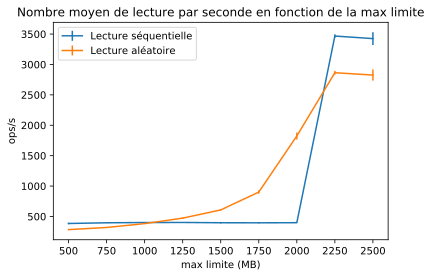

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

SEQ_FILES = []
RAND_FILES = []

SEQ_DIR = 'seqread'
RAND_DIR = 'randread'
LABELS = [500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500]

for i in LABELS:
    SEQ_FILES.append('%s/filemicro_seqread.f_%sM.out.csv' % (SEQ_DIR, i))
    RAND_FILES.append('%s/filemicro_randread.f_%sM.out.csv' % (RAND_DIR, i))

seq_means = []
seq_stds = []

rand_means = []
rand_stds = []

for file in SEQ_FILES:
    df = pd.read_csv(file, ';')
    values = df.values
    
    seq_means.append(values.mean(0)[1])
    seq_stds.append(values.std(0)[1])
    
for file in RAND_FILES:
    df = pd.read_csv(file, ';')
    values = df.values
    
    rand_means.append(values.mean(0)[1])
    rand_stds.append(values.std(0)[1])

# Axis and figure initialization.
# We need two axis: one for memory usage and the other for reads from disk.
fig, ax = plt.subplots()

ax.errorbar(LABELS, seq_means, yerr = seq_stds, label = 'Lecture séquentielle')
ax.errorbar(LABELS, rand_means, yerr = rand_stds, label = 'Lecture aléatoire') 

ax.legend(loc = 'best')
ax.set_ylabel('ops/s')
ax.set_xlabel('max limite (MB)')
ax.set_title('Nombre moyen de lecture par seconde en fonction de la max limite')
    
# Print the figure.
set_matplotlib_formats('svg')
plt.show()

Les écarts-types sont faibles donc les résultats sont assez stables.

La courbe des lectures séquentielles présente bien deux groupes :
* un groupe de valeur avec de mauvaises performances
* et un groupe de valeur avec de bonnes performances
Il n'y a pas de juste milieu car dès que le fichier lu tient en mémoire les performances sont excellentes.

La courbe des lectures aléatoires a par contre une forme plus proche de l'exponentielle où plus la mémoire est grande plus la probabilité d'accèder à un bloc déjà accédé est grande. Néanmoins cette exponentielle possède un seuil à partir duquel les performances se stabilisent car le fichier tient en mémoire.

Comme lors de l'expérience précédent on peut voir que la bande passante aléatoire est inférieure à la bande passante séquentielle.

### Conclusion
Les deux charges de travail n'ont pas du tout la même répartition de performance. La charge séquentielle est binaire tandis que la charge aléatoire présente plus de nuances.